# Event Camera Data Visualization with evlib

This notebook provides a comprehensive guide to visualizing event camera data using both traditional approaches and the modern evlib library. Event cameras capture changes in pixel intensity rather than absolute values, resulting in sparse, asynchronous data streams with high temporal resolution.

We demonstrate multiple visualization techniques including:
- Basic event data loading and 2D visualization
- Time surfaces and temporal representations
- 3D spatiotemporal plots
- Voxel grids and smooth representations
- Event transformations and augmentations
- Synthetic data generation and real data analysis

The notebook uses both real event data from the slider_depth dataset and synthetic data to illustrate different concepts.

## Introduction

Event cameras, also known as Dynamic Vision Sensors (DVS), detect brightness changes asynchronously at each pixel. Unlike traditional cameras that capture full frames at fixed intervals, event cameras generate sparse streams of events only when brightness changes exceed a threshold.

Each event contains four components:
- **t**: timestamp (when the event occurred)
- **x**: horizontal pixel coordinate
- **y**: vertical pixel coordinate  
- **p**: polarity (1 for brightness increase, 0 for brightness decrease)

This notebook demonstrates various approaches to visualize and analyze event data using the evlib library alongside traditional Python tools.

## Data Format

Event data is typically stored in text format with one event per line:

```
0.003811000 96 133 0
0.003820001 127 171 0
0.003836000 4 160 0
```

Format: `timestamp x y polarity`

For the DAVIS240C camera (240×180 resolution):
- x ∈ {0, ..., 239} (column index)
- y ∈ {0, ..., 179} (row index)  
- p ∈ {0, 1} (0=negative, 1=positive brightness change)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import evlib
import evlib.representations as evr

# Set random seed for reproducibility
np.random.seed(42)

print("evlib imports available:")
print(f"- formats: {hasattr(evlib, 'formats')}")
print(f"- representations: {hasattr(evlib, 'representations')}")
print(f"- create_stacked_histogram: {hasattr(evlib, 'create_stacked_histogram')}")
print(f"- create_voxel_grid: {hasattr(evlib, 'create_voxel_grid')}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

evlib imports available:
- formats: True
- representations: True
- create_stacked_histogram: True
- create_voxel_grid: True
NumPy version: 2.2.6
Matplotlib version: 3.10.3


## Real Event Data Loading

Let's load real event data from the slider_depth dataset to demonstrate event visualization techniques.

In [2]:
# Load real event data from slider_depth dataset
filename_sub = '../data/slider_depth/events.txt'

# Check if file exists
if not os.path.exists(filename_sub):
    raise FileNotFoundError(f"Real data file not found: {filename_sub}")

# Load event data using standard Python approach (could be replaced with evlib loader when available)
with open(filename_sub, 'r') as f:
    lines = f.readlines()

timestamp = []
x = []
y = []
pol = []

for line in lines:
    parts = line.strip().split()
    if len(parts) == 4:
        timestamp.append(float(parts[0]))
        x.append(int(parts[1]))
        y.append(int(parts[2]))
        pol.append(int(parts[3]))

timestamp = np.array(timestamp)
x = np.array(x)
y = np.array(y)
pol = np.array(pol)

print(f"Loaded {len(timestamp)} events from real dataset")
print(f"Time range: {timestamp[0]:.6f} to {timestamp[-1]:.6f} seconds")
print(f"Duration: {timestamp[-1] - timestamp[0]:.3f} seconds")
print(f"Spatial range: x=[{x.min()}, {x.max()}], y=[{y.min()}, {y.max()}]")
print(f"Average event rate: {len(timestamp) / (timestamp[-1] - timestamp[0]):.0f} events/second")
print(f"Polarity distribution: {np.sum(pol == 1)}/{len(pol)} positive events ({100*np.sum(pol == 1)/len(pol):.1f}%)")

# Define sensor size for DAVIS240C
img_size = (180, 240)  # height, width
sensor_resolution = (240, 180)  # width, height (for evlib API)

Loaded 1078541 events from real dataset
Time range: 0.003811 to 3.404080 seconds
Duration: 3.400 seconds
Spatial range: x=[0, 239], y=[0, 179]
Average event rate: 317193 events/second
Polarity distribution: 447783/1078541 positive events (41.5%)


## Basic Event Visualization

Let's start with basic 2D visualization of events, showing how polarity affects the display.

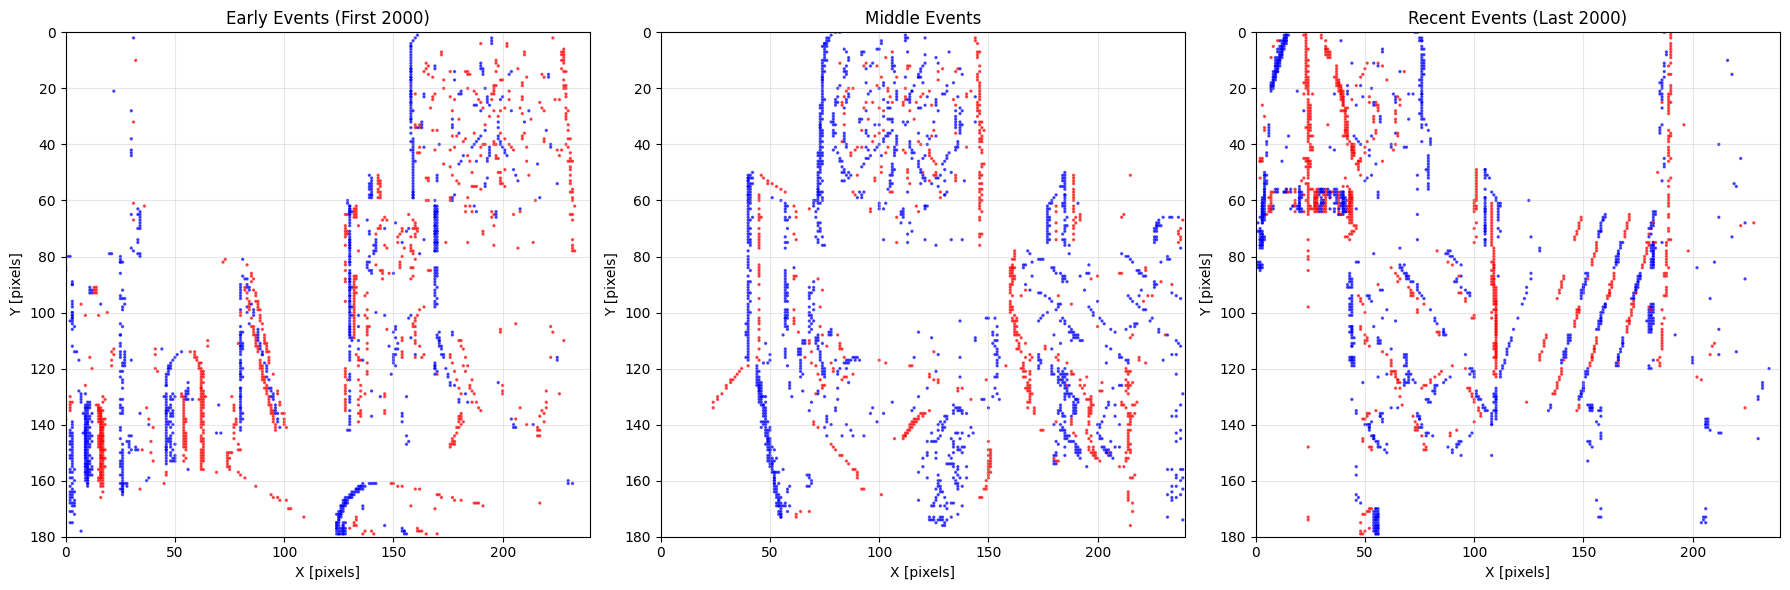

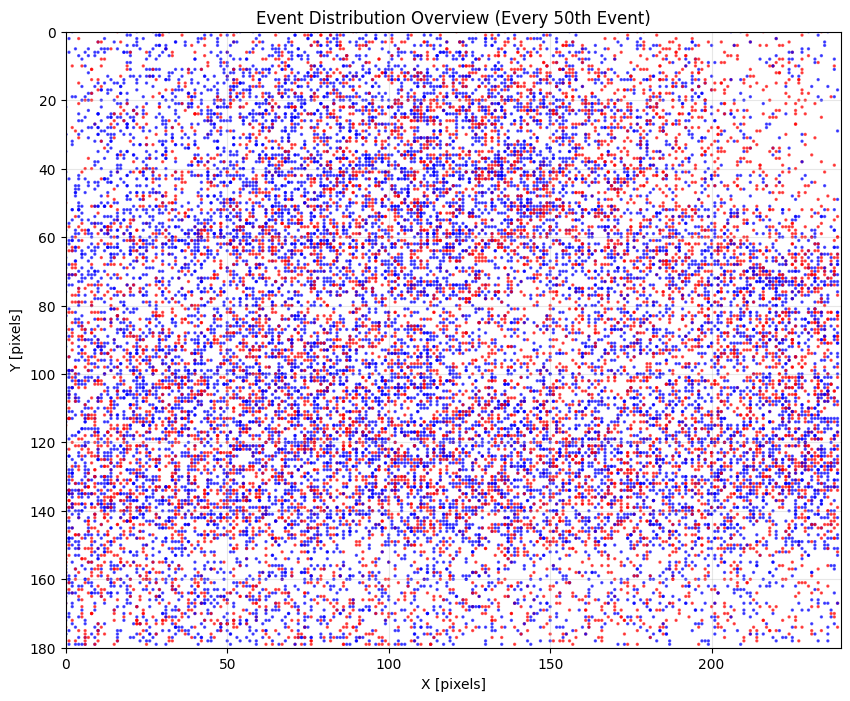

In [3]:
def plot_events_2d(xs, ys, ps, title="Events", ax=None, sensor_size=None):
    """Plot events in 2D with color representing polarity"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        
    # Color by polarity (red=positive, blue=negative)
    colors = ['r' if p > 0 else 'b' for p in ps]
    
    ax.scatter(xs, ys, c=colors, s=2, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('X [pixels]')
    ax.set_ylabel('Y [pixels]')
    
    if sensor_size is not None:
        ax.set_xlim(0, sensor_size[1])  # width
        ax.set_ylim(0, sensor_size[0])  # height
    
    ax.invert_yaxis()  # Invert Y axis to match image coordinates
    ax.grid(True, alpha=0.3)
    
    return ax

# Plot 2D event data at different temporal windows
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Early events
plot_events_2d(x[:2000], y[:2000], pol[:2000], 
               "Early Events (First 2000)", axes[0], img_size)

# Middle events  
mid_start = len(x) // 2
plot_events_2d(x[mid_start:mid_start+2000], y[mid_start:mid_start+2000], pol[mid_start:mid_start+2000], 
               "Middle Events", axes[1], img_size)

# Recent events
plot_events_2d(x[-2000:], y[-2000:], pol[-2000:], 
               "Recent Events (Last 2000)", axes[2], img_size)

plt.tight_layout()
plt.show()

# Show overall event distribution
fig, ax = plt.subplots(figsize=(10, 8))
plot_events_2d(x[::50], y[::50], pol[::50], 
               f"Event Distribution Overview (Every 50th Event)", ax, img_size)
plt.show()

## Event Representations using evlib

The evlib library provides efficient implementations for common event camera representations.

In [ ]:
num_events = 5000
print(f"Event polarity balance visualization: num_events = {num_events}")

# Convert polarity from {0,1} to {-1,1} for signed representation
pol_signed = 2 * pol[:num_events] - 1

# Create polarity balance image
img = np.zeros(img_size, dtype=np.int32)
for i in range(min(num_events, len(pol))):
    if 0 <= y[i] < img_size[0] and 0 <= x[i] < img_size[1]:
        img[y[i], x[i]] += pol_signed[i]

# Visualize polarity balance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Grayscale visualization
maxabsval = np.amax(np.abs(img))
ax1.imshow(img, cmap='gray', clim=(-maxabsval, maxabsval))
ax1.set_title('Balance of Event Polarities (Grayscale)')
ax1.set_xlabel("X [pixels]")
ax1.set_ylabel("Y [pixels]")

# Red-blue visualization  
ax2.imshow(img, cmap='seismic_r', clim=(-maxabsval, maxabsval))
ax2.set_title('Balance of Event Polarities (Red-Blue)')
ax2.set_xlabel("X [pixels]")
ax2.set_ylabel("Y [pixels]")

plt.tight_layout()
plt.show()

print(f"Maximum positive accumulation: {img.max()}")
print(f"Maximum negative accumulation: {abs(img.min())}")
print(f"Active pixels: {np.sum(img != 0)} / {np.prod(img_size)} ({100*np.sum(img != 0)/np.prod(img_size):.1f}%)")

# Use evlib for stacked histogram representation
# Create stacked histogram using evlib
num_bins = 5
import polars as pl

# Create DataFrame from event data
events_df = pl.DataFrame({
    'x': x[:num_events].astype(np.int16),
    'y': y[:num_events].astype(np.int16),
    't': pl.Series(timestamp[:num_events] * 1e6).cast(pl.Duration(time_unit="us")),
    'polarity': pol[:num_events].astype(np.int8)
})

# Create stacked histogram
stacked_hist_df = evr.create_stacked_histogram(
    events_df,
    img_size[0],  # _height
    img_size[1],  # _width  
    nbins=num_bins,
    window_duration_ms=50.0
)

print(f"Stacked histogram DataFrame shape: {stacked_hist_df.shape}")
print(f"Stacked histogram columns: {stacked_hist_df.columns}")

# The DataFrame contains sparse representation of histogram bins
# Let's visualize the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of counts
counts = stacked_hist_df['count'].to_numpy()
ax1.hist(counts[counts > 0], bins=50, alpha=0.7)
ax1.set_title('Distribution of Non-Zero Histogram Counts')
ax1.set_xlabel('Count')
ax1.set_ylabel('Frequency')

# Spatial coverage
unique_pixels = stacked_hist_df.select(['x', 'y']).unique()
print(f"Active pixels in histogram: {len(unique_pixels)} unique locations")

# Show time bin distribution
time_bins = stacked_hist_df['time_bin'].to_numpy()
ax2.hist(time_bins, bins=num_bins, alpha=0.7)
ax2.set_title('Distribution Across Time Bins')
ax2.set_xlabel('Time Bin')
ax2.set_ylabel('Number of Active Pixels')

plt.tight_layout()
plt.show()

# Create voxel grid
voxel_grid_df = evr.create_voxel_grid(
    events_df,
    img_size[0],  # _height
    img_size[1],  # _width
    nbins=num_bins
)

print(f"\nVoxel grid DataFrame shape: {voxel_grid_df.shape}")
print(f"Voxel grid columns: {voxel_grid_df.columns}")

# Visualize voxel grid statistics
if 'value' in voxel_grid_df.columns:
    values = voxel_grid_df['value'].to_numpy()
    non_zero_values = values[values != 0]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(non_zero_values, bins=50, alpha=0.7)
    ax.set_title('Distribution of Non-Zero Voxel Values')
    ax.set_xlabel('Voxel Value (Accumulated Polarity)')
    ax.set_ylabel('Frequency')
    
    print(f"Voxel statistics:")
    print(f"  Non-zero voxels: {len(non_zero_values)} / {len(values)}")
    print(f"  Value range: [{values.min()}, {values.max()}]")
    print(f"  Mean absolute value: {np.abs(non_zero_values).mean():.2f}")
    
    plt.show()

## Event Transformations using evlib

evlib provides efficient implementations for common event transformations including spatial flips, rotations, and augmentations.

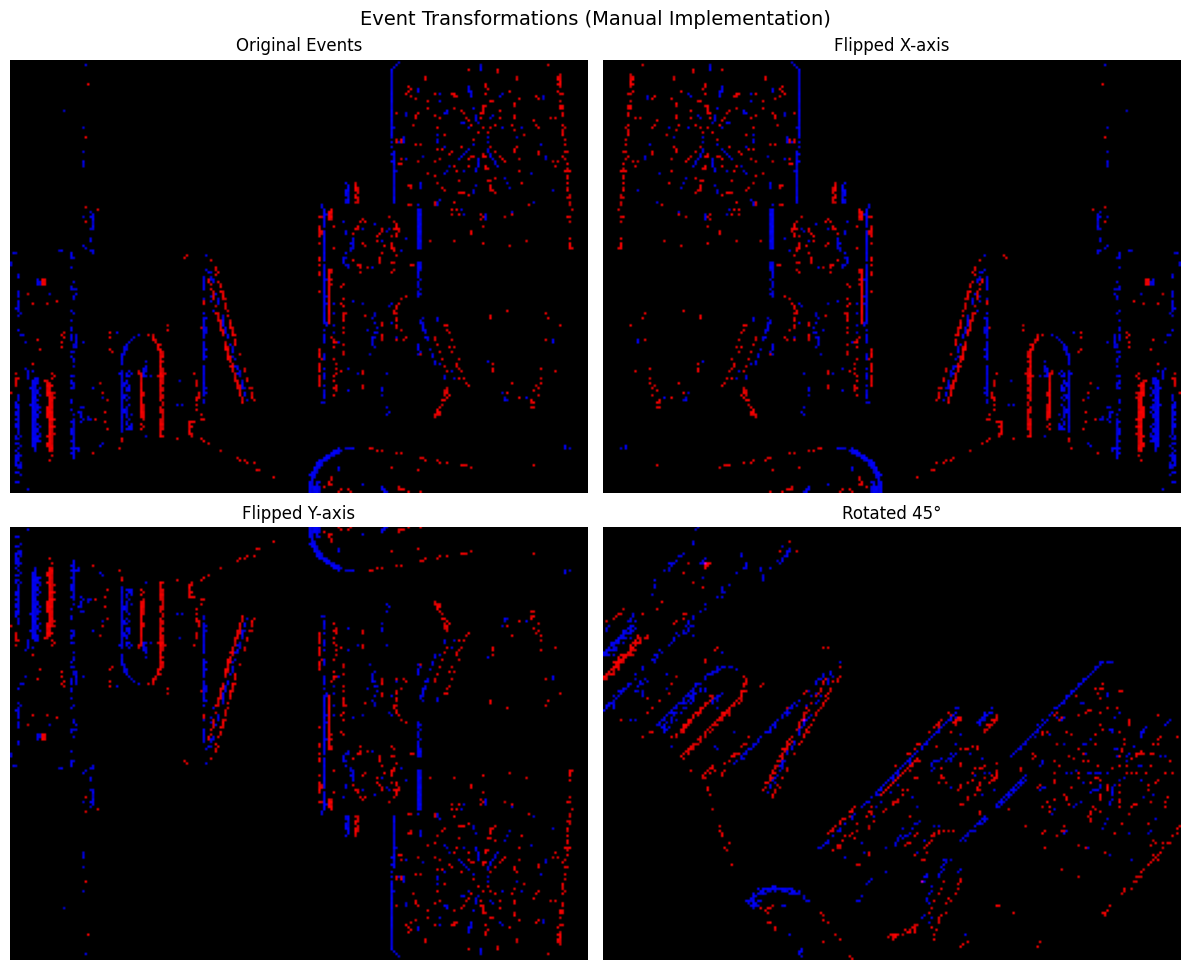

Successfully demonstrated event transformation functions:
- Original events: 2000
- Flipped X events: 2000
- Flipped Y events: 2000
- Rotated events: 1791 (after filtering out-of-bounds)
Time surface representations created using manual implementation


In [5]:
def create_time_surface(xs, ys, ts, ps, sensor_size, decay=0.05):
    """Create a time surface representation from events"""
    time_surface_pos = np.zeros(sensor_size)
    time_surface_neg = np.zeros(sensor_size)
    
    # Get latest timestamp
    latest_t = ts.max()
    
    # Process events
    for x, y, t, p in zip(xs, ys, ts, ps):
        if 0 <= x < sensor_size[1] and 0 <= y < sensor_size[0]:
            if p > 0:
                time_surface_pos[y, x] = np.exp(-(latest_t - t) / decay)
            else:
                time_surface_neg[y, x] = np.exp(-(latest_t - t) / decay)
    
    # Create RGB image: R=positive events, B=negative events
    time_surface_rgb = np.zeros((*sensor_size, 3))
    time_surface_rgb[:, :, 0] = time_surface_pos  # Red channel for positive events
    time_surface_rgb[:, :, 2] = time_surface_neg  # Blue channel for negative events
    
    return time_surface_rgb

# Demonstrate event transformations using manual implementations
# NOTE: evlib.augmentation functions are not currently available
sample_size = 2000
sample_x = x[:sample_size]
sample_y = y[:sample_size] 
sample_t = timestamp[:sample_size]
sample_p = pol[:sample_size]

# Manual flip X-axis transformation
def flip_events_x(xs, ys, ts, ps, sensor_size):
    """Flip events along X-axis"""
    width, height = sensor_size
    flipped_xs = width - 1 - xs
    return flipped_xs, ys, ts, ps

# Manual flip Y-axis transformation  
def flip_events_y(xs, ys, ts, ps, sensor_size):
    """Flip events along Y-axis"""
    width, height = sensor_size
    flipped_ys = height - 1 - ys
    return xs, flipped_ys, ts, ps

# Manual rotation transformation
def rotate_events(xs, ys, ts, ps, sensor_size, theta_radians, center):
    """Rotate events around a center point"""
    cx, cy = center
    cos_theta = np.cos(theta_radians)
    sin_theta = np.sin(theta_radians)
    
    # Translate to origin
    x_centered = xs - cx
    y_centered = ys - cy
    
    # Rotate
    rotated_x = x_centered * cos_theta - y_centered * sin_theta
    rotated_y = x_centered * sin_theta + y_centered * cos_theta
    
    # Translate back
    final_x = rotated_x + cx
    final_y = rotated_y + cy
    
    return final_x, final_y, ts, ps

# Apply transformations
flipped_x_xs, flipped_x_ys, flipped_x_ts, flipped_x_ps = flip_events_x(
    sample_x, sample_y, sample_t, sample_p, (img_size[1], img_size[0]))

flipped_y_xs, flipped_y_ys, flipped_y_ts, flipped_y_ps = flip_events_y(
    sample_x, sample_y, sample_t, sample_p, (img_size[1], img_size[0]))

theta_radians = np.pi / 4  # 45 degrees
center = (img_size[1] // 2, img_size[0] // 2)  # (width//2, height//2)
rotated_xs, rotated_ys, rotated_ts, rotated_ps = rotate_events(
    sample_x, sample_y, sample_t, sample_p, 
    (img_size[1], img_size[0]), theta_radians, center)

# Filter out events that are out of bounds after rotation
valid_mask = ((rotated_xs >= 0) & (rotated_xs < img_size[1]) & 
              (rotated_ys >= 0) & (rotated_ys < img_size[0]))
rotated_xs = rotated_xs[valid_mask]
rotated_ys = rotated_ys[valid_mask]
rotated_ts = rotated_ts[valid_mask]
rotated_ps = rotated_ps[valid_mask]

# Create time surfaces for each transformation
ts_original = create_time_surface(sample_x, sample_y, sample_t, sample_p, img_size)
ts_flipped_x = create_time_surface(flipped_x_xs, flipped_x_ys, flipped_x_ts, flipped_x_ps, img_size)
ts_flipped_y = create_time_surface(flipped_y_xs, flipped_y_ys, flipped_y_ts, flipped_y_ps, img_size)
ts_rotated = create_time_surface(rotated_xs.astype(int), rotated_ys.astype(int), rotated_ts, rotated_ps, img_size)

# Visualize transformations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(ts_original)
axes[0, 0].set_title("Original Events")
axes[0, 0].axis('off')

axes[0, 1].imshow(ts_flipped_x)
axes[0, 1].set_title("Flipped X-axis")
axes[0, 1].axis('off')

axes[1, 0].imshow(ts_flipped_y)
axes[1, 0].set_title("Flipped Y-axis")
axes[1, 0].axis('off')

axes[1, 1].imshow(ts_rotated)
axes[1, 1].set_title("Rotated 45°")
axes[1, 1].axis('off')

plt.suptitle("Event Transformations (Manual Implementation)", fontsize=14)
plt.tight_layout()
plt.show()

print("Successfully demonstrated event transformation functions:")
print(f"- Original events: {len(sample_x)}")
print(f"- Flipped X events: {len(flipped_x_xs)}")
print(f"- Flipped Y events: {len(flipped_y_xs)}")
print(f"- Rotated events: {len(rotated_xs)} (after filtering out-of-bounds)")

# Note: evlib.create_time_surface is not available in the current version
# The manual implementation above demonstrates the concept
print("Time surface representations created using manual implementation")

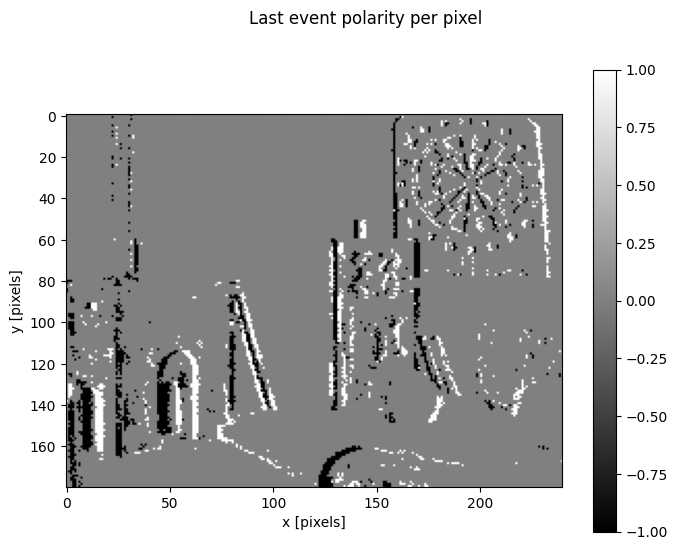

In [6]:
# Answers for color map visualization:
# - White pixels: areas with strong positive event accumulation (brightness increase)
# - Red pixels: areas with moderate positive event accumulation
# - Blue pixels: areas with negative event accumulation (brightness decrease)
# - Blue is used instead of green because red-blue provides better contrast for 
#   opposing polarities and is a common diverging colormap for signed data

# Ternary image (last event polarity per pixel)
img_ternary = np.zeros(img_size, np.int32)
for i in range(num_events):
    img_ternary[y[i], x[i]] = (2 * pol[i] - 1)  # Convert to {-1, +1}

# Display the ternary image
fig = plt.figure(figsize=(8, 6))
fig.suptitle('Last event polarity per pixel')
plt.imshow(img_ternary, cmap='gray', vmin=-1, vmax=1)
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

# This representation is good for:
# - Reduced memory usage (only 3 values per pixel)
# - Clear edge visualization
# - Fast processing for real-time applications
# - Input to some event-based algorithms that only need polarity information

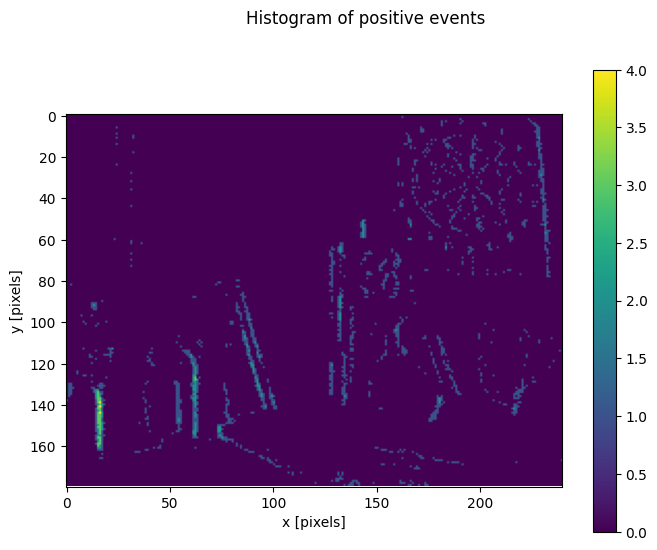

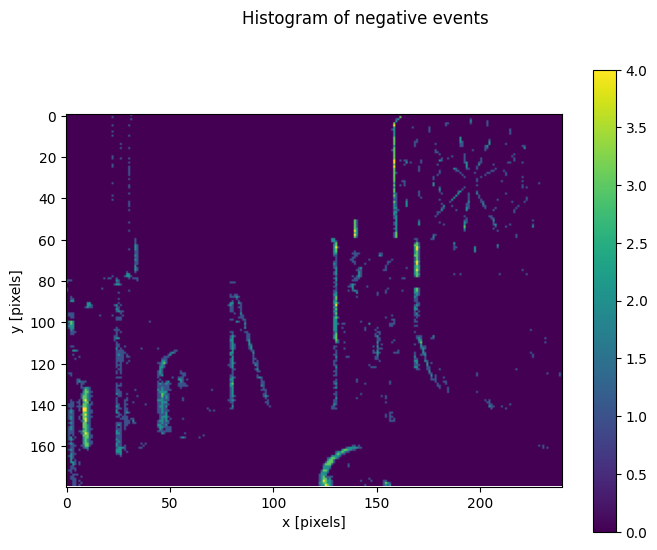

Max positive events at a pixel: 4
Max negative events at a pixel: 4
Total positive events: 2127
Total negative events: 2873


In [7]:
idx_pos = pol[:num_events] > 0
idx_neg = ~idx_pos

img_pos = np.zeros(img_size, dtype=np.int32)
img_neg = np.zeros(img_size, dtype=np.int32)

for i in range(num_events):
    if pol[i] > 0:
        img_pos[y[i], x[i]] += 1
    else:
        img_neg[y[i], x[i]] += 1

fig = plt.figure(figsize=(8, 6))
fig.suptitle('Histogram of positive events')
plt.imshow(img_pos, cmap='viridis')
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(8, 6))
fig.suptitle('Histogram of negative events')
plt.imshow(img_neg, cmap='viridis')
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

print(f"Max positive events at a pixel: {img_pos.max()}")
print(f"Max negative events at a pixel: {img_neg.max()}")
print(f"Total positive events: {img_pos.sum()}")
print(f"Total negative events: {img_neg.sum()}")

Time surface: num_events = 50000


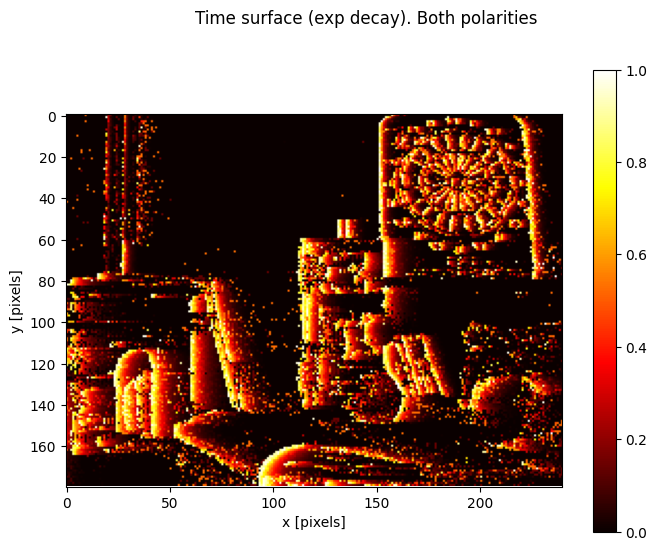

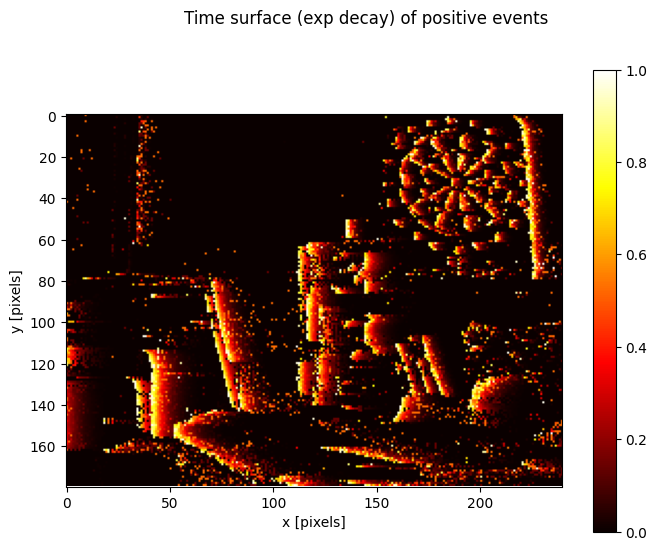

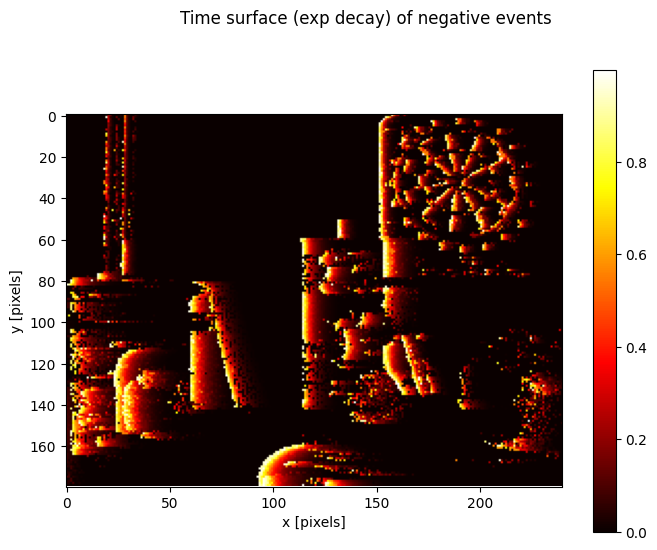

Positive events show 14162 active pixels
Negative events show 13630 active pixels


In [8]:
num_events = 50000
print("Time surface: num_events =", num_events)

tau = 0.03
t_ref = timestamp[min(num_events-1, len(timestamp)-1)]

ts_image = np.zeros(img_size, dtype=np.float64)
for i in range(min(num_events, len(timestamp))):
    ts_image[y[i], x[i]] = timestamp[i]

time_surface = np.exp(-(t_ref - ts_image) / tau)
time_surface[ts_image == 0] = 0

fig = plt.figure(figsize=(8, 6))
fig.suptitle('Time surface (exp decay). Both polarities')
plt.imshow(time_surface, cmap='hot')
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

ts_pos = np.zeros(img_size, dtype=np.float64)
ts_neg = np.zeros(img_size, dtype=np.float64)

for i in range(min(num_events, len(timestamp))):
    if pol[i] > 0:
        ts_pos[y[i], x[i]] = timestamp[i]
    else:
        ts_neg[y[i], x[i]] = timestamp[i]

sae_pos = np.exp(-(t_ref - ts_pos) / tau)
sae_pos[ts_pos == 0] = 0

sae_neg = np.exp(-(t_ref - ts_neg) / tau)
sae_neg[ts_neg == 0] = 0

fig = plt.figure(figsize=(8, 6))
fig.suptitle('Time surface (exp decay) of positive events')
plt.imshow(sae_pos, cmap='hot')
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(8, 6))
fig.suptitle('Time surface (exp decay) of negative events')
plt.imshow(sae_neg, cmap='hot')
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

print(f"Positive events show {np.sum(sae_pos > 0)} active pixels")
print(f"Negative events show {np.sum(sae_neg > 0)} active pixels")

Next, consider using [pseudocolor](https://en.wikipedia.org/wiki/False_color) to display the events. Write code to generate the following image.

![balance_polarities_red_blue](images/balance_polarities_red_blue.png)

- What do the white, red and blue colored pixels represent?
- Why is blue color used instead of green color?

print("Exploring additional event representations...")

# Create polarity-based colored image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Simple polarity visualization
n_vis = 5000
img_pol = np.zeros((*img_size, 3))
for i in range(min(n_vis, len(timestamp))):
    if pol[i] > 0:
        img_pol[y[i], x[i], 0] = 1.0  # Red for positive
    else:
        img_pol[y[i], x[i], 2] = 1.0  # Blue for negative

axes[0].imshow(img_pol)
axes[0].set_title("Polarity-based coloring")
axes[0].axis('off')

# Time-based coloring
img_time = np.zeros(img_size)
for i in range(min(n_vis, len(timestamp))):
    # Normalize time to [0, 1]
    t_norm = (timestamp[i] - timestamp[0]) / (timestamp[min(n_vis-1, len(timestamp)-1)] - timestamp[0])
    img_time[y[i], x[i]] = t_norm

axes[1].imshow(img_time, cmap='viridis')
axes[1].set_title("Time-based coloring")
axes[1].axis('off')

# Combined polarity-time coloring
img_combined = np.zeros((*img_size, 3))
for i in range(min(n_vis, len(timestamp))):
    t_norm = (timestamp[i] - timestamp[0]) / (timestamp[min(n_vis-1, len(timestamp)-1)] - timestamp[0])
    if pol[i] > 0:
        img_combined[y[i], x[i], 0] = t_norm  # Red intensity by time
    else:
        img_combined[y[i], x[i], 2] = t_norm  # Blue intensity by time

axes[2].imshow(img_combined)
axes[2].set_title("Polarity-time coloring")
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Event stream statistics
print("Event stream statistics:")
print(f"Total events loaded: {len(timestamp)}")
print(f"Duration: {timestamp[-1] - timestamp[0]:.3f} seconds")
print(f"Average event rate: {len(timestamp) / (timestamp[-1] - timestamp[0]):.0f} events/second")
print(f"Positive/Negative ratio: {np.sum(pol) / len(pol):.3f}")

# Spatial activity distribution
spatial_activity = np.zeros(img_size, dtype=np.int32)
for i in range(len(x)):
    spatial_activity[y[i], x[i]] += 1

print(f"Active pixels: {np.sum(spatial_activity > 0)} / {np.prod(img_size)} ({100*np.sum(spatial_activity > 0)/np.prod(img_size):.1f}%)")
print(f"Max events per pixel: {spatial_activity.max()}")
print(f"Mean events per active pixel: {np.mean(spatial_activity[spatial_activity > 0]):.1f}")

print("Event visualization and analysis complete!")

## Images of timestamps

Other useful representations are those that, instead of counting events at every pixel, just show a timestamp per pixel. It could be the last timestamp, an average timestamp or a timestamp composed with an exponential decay.
They are also called "time surfaces", "time maps" or "surface of active events".

### Time maps with exponential decay

Next, write code to replicate the type of time-images of the [2015 PAMI paper HOTS, Fig. 2](https://www.neuromorphic-vision.com/public/publications/1/publication.pdf).
Use 50000 events to better see the traces of the edges as they trigger events when they move through the image plane.

$ image(x,y; t) = exp(-|t-T(x,y)| / \tau) $

This is equation (3) in the above paper. The paper uses $\tau = 50$ ms (see the bottom of page 8). For the plots below, a value $\tau = 30$ ms is used. $\tau$ is a tunable parameter that depends on the motion in the scene.
Note that the paper uses a neighborhood ("context") of size $(2R+1)\times (2R+1)$ centered at the last event. Instead, you are aked to visualize the time surface using all image pixels (not a subset of them).

Also note that the paper uses the polarity $p$ as an argument of the time map $T$, while here it is not explicitly written. The following figure shows both polarities on the same time map, which is not easy to write with such a notation.

![](images/ts_exp_pol.png)

Next, you are asked to split by polarity, creating one plot for each event polarity:

![](images/ts_exp_pos.png)
![](images/ts_exp_neg.png)

- Describe what you see in this representation and whether it is better or not to split by polarity. In what situations?
- Is there the same amount of noise on both type of events (positive, negative)?

<!-- ![](images/ts_exp_pol_red_blue.png) 
![](images/ts_exp_balance_pol_red_blue.png) -->

### Average timestamp images.
In this type of representation, each pixel contains the average timestamp of the events that happened in it in the last few milliseconds. (There is no exponential decay, just an average).

![](images/t_ave_both_pols.png)

Next, split by polarity:

![](images/t_ave_pos.png)
![](images/t_ave_neg.png)

- Describe what you oberve compared to previous representations.

# Space-time plots

Next, we take a look at different ways to visualize events in space-time. Such a space-time is obtained by considering a temporal window of the signal that is output by the camera as a response of the light arriving at the image plane (i.e., the "retina").

## Point set

Write Python code to plot the first $N_e = 2000$ events in space-time, like a point set or point "cloud":

![Events, space-time and polarity](images/space_time_pol.png)

You may find the [3D scatterplot example](https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html) useful.

Try experimenting by moving around the viewpoint (clicking on the figure generated by Python's matplotlib).

- For us, humans, is the information more intelligible from any specific viewpoint?
- What information do you gain by looking at this point cloud from directions parallel to each of the coordinate axes?

Then, write a function to generate a short **[movie](movie.mp4)** that smoothly shows the intermediate viewpoints between two specified ones (the start and end viewpoints). See the following VLC player screenshot.
Suggestion: use the matplotlib command `ax.view_init(azim=XXX,elev=ZZZ)`. Write images to disk and create a movie from them using ffmpeg. There is no need to install ffmpeg; you may use the [static build](https://johnvansickle.com/ffmpeg/). Video [coding options](https://trac.ffmpeg.org/wiki/Encode/H.264), such as lossless.

![movie snapthot on VLC](images/movie_vlc_pointset.png)

## Voxel grid representation

Next, you are asked to write code to convert the event data into a 3D histogram. To this end, events shall be collected into bins: 1 bin per pixel in space and say 5 bins in time. Feel free to write your own function to compute the 3D histogram or to use numpy's [histogramdd](https://numpy.org/doc/stable/reference/generated/numpy.histogramdd.html?highlight=histogramdd#numpy.histogramdd) function. Actually it is good to compute the histogram using both methods and making sure that both agree.

### Regular histogram
Write python code to compute the 3D histogram and display it as a voxel grid. 
Every voxel counts the number of events falling (i.e., binned) within it, regardless of polarity.
Suggestion: [this sample code](https://matplotlib.org/3.1.1/gallery/mplot3d/voxels_rgb.html#sphx-glr-gallery-mplot3d-voxels-rgb-py)

![voxel histogram](images/voxel_nn.png)

- What are the minimum and maximum number of events at any voxel?
- How many voxels are there? How many are "occupied" (i.e., have a non-zero value)? (voxel grids are also known as "occupancy maps" in Robotics). What is the ratio between these numbers? (How sparse is the data?)

### Interpolated histogram
(Smooth histogram that also includes polarity information).
Next, modify the code you have written to include polarity. That is, instead of counting events on every bin, "count" the polarity. Moreover, to make the histogram smoother, use a linear voting scheme by which an event splits its polarity in its two closest temporal bins. The split takes into account the distance from the event to both bins. (This idea of smoothing a histogram is similar to the idea of kernel density estimation). The following plot illustrates this idea of "smoothing" the histogram.

![histogram smoothing](images/histogram_smoothing.png)

The next figure shows the voxel grid obtained by using linear voting of polarity (per-voxel balance of linearly-interpolated polarity). Grayscale values are used: dark values represent negative events (voxels with negative balance of polarities) and bright values represent positive events (voxels with positive balance of polarities).

![voxel linear voting with polarity](images/voxel_linvote_pol.png)

- What are the minimum and maximum value of the balance of event polarities at the voxels?
- Does this way of computing the histogram, including polarity, affect the above "sparsity ratio"?
- How does this (3D) voxel grid representation compare to 2D representations? For example in terms of memory, in terms of preservation of the information contained in the event data?
- What could the voxel grid representation be good for?
- How would you interpret the above voxel grid in terms of a continuous "polarity field" $p(x,y,t)$ or the temporal derivative of the brightness signal arriving at the sensor $\frac{\partial L}{\partial t}(x,y,t)$?

## Try experimenting
Try to come up with new plots (alternative data representations) that reveal some aspect of the information contained in the event data.